### **Limpando e processando os dados**
 
Para que o computador compreenda nossa linguagem é importante realizar algumas transformações no intuito de faciliar essa compreensão. Para isso, primeiramente podemos realizar a **limpeza dos dados**, que consiste na **remoção de caracteres que não contribui** na distinção dos sentimentos dos comentários dos nossos clientes, podemos citar por exemplos, remover caracteres especiais e espaços no início e fim dos comentários.


Logo após a limpeza de caracteres não relevantes, precisamos realizar o procedimento de **Tokenização**, que consiste no processo de **dividir uma frase** em palavras ou tokens (parte do texto) individuais.

E para finalizar o processamento dos nossos dados, iremos realizar a retirada de **stopwords**, ou seja, aquelas palavras que não auxiliam na classificação ou identificação do texto, em sua maioria são **preposições, artigos, pronomes .**..
 
 

In [ ]:
#Lembrando como estão nossos dados
dados.limit(10).show()

+---+--------------------+--------------------+---------+
| id|             text_en|             text_pt|sentiment|
+---+--------------------+--------------------+---------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|
|  2|This is an exampl...|Este é um exemplo...|      neg|
|  3|First of all I ha...|Primeiro de tudo ...|      neg|
|  4|Not even the Beat...|Nem mesmo os Beat...|      neg|
|  5|Brass pictures mo...|Filmes de fotos d...|      neg|
|  6|A funny thing hap...|Uma coisa engraça...|      neg|
|  7|This German horro...|Este filme de ter...|      neg|
|  8|Being a long-time...|Sendo um fã de lo...|      neg|
|  9|"Tokyo Eyes" tell...|"Tokyo Eyes" fala...|      neg|
| 10|Wealthy horse ran...|Fazendeiros ricos...|      neg|
+---+--------------------+--------------------+---------+



### **WordCloud**

A nuvem de palavras é um recurso visual muito utilizado para entender as palavras mais frequentes de um texto. Aqui usaremos a própria biblioteca do Python `WordCloud`. 

A ideia é coletar as palavras usando *list comprehension* e aplicando a função `collect()` em uma [amostra](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.sample.html), já que esta função exige muitos recursos de processamento do spark.


In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

amostra = dados.select('text_pt').sample(fraction = 0.1, seed = 101)
tudo = [texto['text_pt'] for texto in amostra.collect()]

In [ ]:
wordcloud = WordCloud(background_color = 'white',
                      width = 1000,
                      height = 600,
                      collocations = False, 
                      prefer_horizontal = 1).generate(str(tudo))

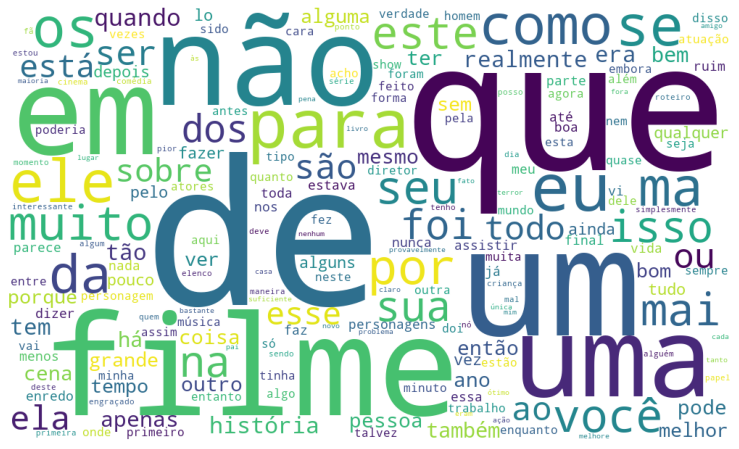

In [ ]:
plt.figure(figsize=(20,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

#### **Limpeza**: caracteres especiais

In [ ]:
# queremos remover esses tipos de caracteres
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
# exemplo de dataframe para a limpeza de caracteres especiais
amostra = spark.createDataFrame([
       ("Oi, JP! Blz?",),
       ("$$$\\ |~ Parabéns ~| \\$$$",),
       ("(#amovc #paz&amor ^.^)",),
       ("\"bora *_* \"",),
       ("=>->'...``` vc foi selecionad@ ´´´...'<=<-",),
       ("{comprar: arroz; feijão e pepino}  //",),
       ("!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~",),
       ("ana@gmail.com",)
], ["textos"])


In [ ]:
#amostra.show(truncate=False)
import pyspark.sql.functions as f

amostra = amostra.withColumn("texto_regex", f.regexp_replace("textos", "[\$#,\"!%&'()*+-./:;<=>?@^_`´{|}~\\\\]", ""))

In [ ]:
amostra.show(truncate = False)

+------------------------------------------+-------------------------------+
|textos                                    |texto_regex                    |
+------------------------------------------+-------------------------------+
|Oi, JP! Blz?                              |Oi JP Blz                      |
|$$$\ |~ Parabéns ~| \$$$                  |  Parabéns                     |
|(#amovc #paz&amor ^.^)                    |amovc pazamor                  |
|"bora *_* "                               |bora                           |
|=>->'...``` vc foi selecionad@ ´´´...'<=<-| vc foi selecionad             |
|{comprar: arroz; feijão e pepino}  //     |comprar arroz feijão e pepino  |
|!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~          |[]                             |
|ana@gmail.com                             |anagmailcom                    |
+------------------------------------------+-------------------------------+



In [ ]:
# Tirando os espaços em brancos no exemplo.
amostra = amostra.withColumn("texto_limpo", f.trim(amostra.texto_regex))
amostra.show(truncate = False)

+------------------------------------------+-------------------------------+-----------------------------+
|textos                                    |texto_regex                    |texto_limpo                  |
+------------------------------------------+-------------------------------+-----------------------------+
|Oi, JP! Blz?                              |Oi JP Blz                      |Oi JP Blz                    |
|$$$\ |~ Parabéns ~| \$$$                  |  Parabéns                     |Parabéns                     |
|(#amovc #paz&amor ^.^)                    |amovc pazamor                  |amovc pazamor                |
|"bora *_* "                               |bora                           |bora                         |
|=>->'...``` vc foi selecionad@ ´´´...'<=<-| vc foi selecionad             |vc foi selecionad            |
|{comprar: arroz; feijão e pepino}  //     |comprar arroz feijão e pepino  |comprar arroz feijão e pepino|
|!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~    

In [ ]:
#1. retirando os caracteres especiais dos dados
dados = dados.withColumn("texto_regex", f.regexp_replace("text_en", "[\$#,\"!%&'()*+-./:;<=>?@^_`´{|}~\\\\]", ""))


In [ ]:
dados.limit(2).show(truncate=False)

+---+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
#2. tirar espaços do começo e do final de cada frase:
# poderiamos usar regex, mas vamos usar o trim
dados = dados.withColumn("texto_limpo", f.trim(dados.texto_regex) )

In [ ]:
dados.limit(2).show()

+---+--------------------+--------------------+---------+--------------------+--------------------+
| id|             text_en|             text_pt|sentiment|         texto_regex|         texto_limpo|
+---+--------------------+--------------------+---------+--------------------+--------------------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|Once again Mr Cos...|Once again Mr Cos...|
|  2|This is an exampl...|Este é um exemplo...|      neg|This is an exampl...|This is an exampl...|
+---+--------------------+--------------------+---------+--------------------+--------------------+



#### **Tokenização**: divisão em tokens

In [ ]:
#3. tokenizando os dados
from pyspark.ml.feature import Tokenizer

tokenizer = Tokenizer(inputCol = "texto_limpo", outputCol = "tokens")
tokenizado = tokenizer.transform(dados)

In [ ]:
tokenizado.select("texto_limpo", "tokens").show()

+--------------------+--------------------+
|         texto_limpo|              tokens|
+--------------------+--------------------+
|Once again Mr Cos...|[once, again, mr,...|
|This is an exampl...|[this, is, an, ex...|
|First of all I ha...|[first, of, all, ...|
|Not even the Beat...|[not, even, the, ...|
|Brass pictures mo...|[brass, pictures,...|
|A funny thing hap...|[a, funny, thing,...|
|This German horro...|[this, german, ho...|
|Being a longtime ...|[being, a, longti...|
|Tokyo Eyes tells ...|[tokyo, eyes, tel...|
|Wealthy horse ran...|[wealthy, horse, ...|
|Cage plays a drun...|[cage, plays, a, ...|
|First of all I wo...|[first, of, all, ...|
|So tell me  what ...|[so, tell, me, , ...|
|A big disappointm...|[a, big, disappoi...|
|This film is abso...|[this, film, is, ...|
|Heres a decidedly...|[heres, a, decide...|
|At the bottom end...|[at, the, bottom,...|
|Earth has been de...|[earth, has, been...|
|Many people are s...|[many, people, ar...|
|New York family i...|[new, york

In [ ]:
from pyspark.sql.types import IntegerType
# Entendendo em quantos tokens os comentários foram divididos.
countTokens = f.udf(lambda tokens: len(tokens), IntegerType())
tokenizado.select("texto_limpo", "tokens")\
          .withColumn("Freq_tokens", countTokens(f.col("tokens"))).show()

+--------------------+--------------------+-----------+
|         texto_limpo|              tokens|Freq_tokens|
+--------------------+--------------------+-----------+
|Once again Mr Cos...|[once, again, mr,...|        168|
|This is an exampl...|[this, is, an, ex...|        232|
|First of all I ha...|[first, of, all, ...|        215|
|Not even the Beat...|[not, even, the, ...|        308|
|Brass pictures mo...|[brass, pictures,...|        238|
|A funny thing hap...|[a, funny, thing,...|        115|
|This German horro...|[this, german, ho...|        156|
|Being a longtime ...|[being, a, longti...|        136|
|Tokyo Eyes tells ...|[tokyo, eyes, tel...|        129|
|Wealthy horse ran...|[wealthy, horse, ...|        160|
|Cage plays a drun...|[cage, plays, a, ...|        109|
|First of all I wo...|[first, of, all, ...|        333|
|So tell me  what ...|[so, tell, me, , ...|        243|
|A big disappointm...|[a, big, disappoi...|        110|
|This film is abso...|[this, film, is, ...|     

#### **StopWords**: remoção de ruídos

Podemos usar o [`StopWordsRemover()`](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.feature.StopWordsRemover.html) nativo do spark, ou o [`stopwords()`](https://openbase.com/js/nltk-stopwords/documentation) da biblioteca nltk do Python. Dentre muitas linguagens, ambas bibliotecas dão suporte para o português.

Vamos começar com um **exemplo pequeno** e depois aplicar em nossos dados.

In [ ]:
# Exemplo pequeno
data = [(1, 'Spark é ótimo e NLP com Spark é fácil'), 
        (0, 'Spark MLlib não ajuda muito'), 
        (1, 'O MLlib do Spark ajuda e é fácil')]
        
colNames = ['label', 'texto_limpo']
df = spark.createDataFrame(data, colNames)

In [ ]:
#Exemplo explorando bibliotecas. (nltk)
import nltk
nltk.download("stopwords")

from nltk.corpus import stopwords
stop_A = stopwords.words("portuguese")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
#Exemplo explorando bibliotecas. (pyspark)
from pyspark.ml.feature import StopWordsRemover

stop_B = StopWordsRemover.loadDefaultStopWords("portuguese")

In [ ]:
# exemplo comparando os diferentes stopwords #A
from pyspark.ml.feature import Tokenizer

tokenizer = Tokenizer(inputCol = "texto_limpo", outputCol = "tokens")
tokenized = tokenizer.transform(df)


In [ ]:
remover = StopWordsRemover(inputCol = "tokens", outputCol = "texto_final", stopWords= stop_A)
df = remover.transform(tokenized)

In [ ]:
df.show(truncate = False)

+-----+-------------------------------------+-----------------------------------------------+---------------------------------+
|label|texto_limpo                          |tokens                                         |texto_final                      |
+-----+-------------------------------------+-----------------------------------------------+---------------------------------+
|1    |Spark é ótimo e NLP com Spark é fácil|[spark, é, ótimo, e, nlp, com, spark, é, fácil]|[spark, ótimo, nlp, spark, fácil]|
|0    |Spark MLlib não ajuda muito          |[spark, mllib, não, ajuda, muito]              |[spark, mllib, ajuda]            |
|1    |O MLlib do Spark ajuda e é fácil     |[o, mllib, do, spark, ajuda, e, é, fácil]      |[mllib, spark, ajuda, fácil]     |
+-----+-------------------------------------+-----------------------------------------------+---------------------------------+



In [ ]:
# exemplo comparando os diferentes stopwords #B
remover = StopWordsRemover(inputCol = "tokens", outputCol = "texto_final", stopWords=stop_B)
df = remover.transform(tokenized)

In [ ]:
df.show(truncate = False)

+-----+-------------------------------------+-----------------------------------------------+---------------------------------------+
|label|texto_limpo                          |tokens                                         |texto_final                            |
+-----+-------------------------------------+-----------------------------------------------+---------------------------------------+
|1    |Spark é ótimo e NLP com Spark é fácil|[spark, é, ótimo, e, nlp, com, spark, é, fácil]|[spark, é, ótimo, nlp, spark, é, fácil]|
|0    |Spark MLlib não ajuda muito          |[spark, mllib, não, ajuda, muito]              |[spark, mllib, ajuda]                  |
|1    |O MLlib do Spark ajuda e é fácil     |[o, mllib, do, spark, ajuda, e, é, fácil]      |[mllib, spark, ajuda, é, fácil]        |
+-----+-------------------------------------+-----------------------------------------------+---------------------------------------+



In [ ]:
# 4. Retirando os stopwords dos depoimentos
remover = StopWordsRemover(inputCol = "tokens", outputCol = "texto_final")
feature_data = remover.transform(tokenizado)


In [ ]:
feature_data.limit(11).show()

+---+--------------------+--------------------+---------+--------------------+--------------------+--------------------+--------------------+
| id|             text_en|             text_pt|sentiment|         texto_regex|         texto_limpo|              tokens|         texto_final|
+---+--------------------+--------------------+---------+--------------------+--------------------+--------------------+--------------------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|Once again Mr Cos...|Once again Mr Cos...|[once, again, mr,...|[mr, costner, dra...|
|  2|This is an exampl...|Este é um exemplo...|      neg|This is an exampl...|This is an exampl...|[this, is, an, ex...|[example, majorit...|
|  3|First of all I ha...|Primeiro de tudo ...|      neg|First of all I ha...|First of all I ha...|[first, of, all, ...|[first, hate, mor...|
|  4|Not even the Beat...|Nem mesmo os Beat...|      neg|Not even the Beat...|Not even the Beat...|[not, even, the, ...|[even, beatles, w...|
|  5|B

In [ ]:
# Contagem de tokens antes e depois do stopwords.
feature_data.select("tokens", "texto_final")\
          .withColumn("Freq_tokens", countTokens(f.col("tokens")))\
          .withColumn("Freq_tokens_limpos",  countTokens(f.col("texto_final"))).show()


+--------------------+--------------------+-----------+------------------+
|              tokens|         texto_final|Freq_tokens|Freq_tokens_limpos|
+--------------------+--------------------+-----------+------------------+
|[once, again, mr,...|[mr, costner, dra...|        168|                73|
|[this, is, an, ex...|[example, majorit...|        232|               131|
|[first, of, all, ...|[first, hate, mor...|        215|               111|
|[not, even, the, ...|[even, beatles, w...|        308|               169|
|[brass, pictures,...|[brass, pictures,...|        238|               140|
|[a, funny, thing,...|[funny, thing, ha...|        115|                52|
|[this, german, ho...|[german, horror, ...|        156|                74|
|[being, a, longti...|[longtime, fan, j...|        136|                73|
|[tokyo, eyes, tel...|[tokyo, eyes, tel...|        129|                75|
|[wealthy, horse, ...|[wealthy, horse, ...|        160|                99|
|[cage, plays, a, ...|[ca

### **Vetorização**


A vetorização dos dados permite transformá-los da linguagem humana e não estruturada para uma maneira mais compreensível ao computador, ou seja, **codificando em números**, sendo possível assim associar cada um dos textos a um sentido e significado delimitados. 


O **Bag of Words**, ou sacola de palavras em português, é uma lista que contém todas as palavras que estão nos textos de maneira não repetida e tem papel importante para **identificar as palavras mais recorrentes** e entender se elas agregam algum sentimento.


Aqui no spark o bag of words não é representado por uma matriz do vocabulário como no python, e sim com uma estrutura específica que cria uma **estrutura especifica** que faciliar a compreensão nos modelos. 

Alternativas para vetorização: matriz_esparsa, countvectorizer, Hashing TF...

